In [15]:
# General libraries
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools



from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from skimage.transform import resize

np.random.seed(0)
import tensorflow
tensorflow.random.set_seed(0)

### 1. Introduction

Our dataset contains 29 classes: one for each letter from A to Z, space, delete, and nothing.  Each example in the dataset is a three-dimensional array of 200 X 200 X 3 pixels.  For the purpose of this project, in the step where the images are loaded from their corresponding sub-folder, we re-size the images to 50 x 50 x 3 to make the run-times of training more managable and reduce the number of pixels from 120,000 to 7,500.

In [16]:
# directory of the training data set
dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/'
file = dir + '{letter}/{letter}{index}.jpg'

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
           'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

label = dict(zip(letters, np.arange(1, 30)))

In [17]:
# Some visualization helpers

def plot_confusion_matrix(cm, classes,
                      normalize=False,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):
    '''
    Plot a confusion matrix heatmap using matplotlib. This code was obtained from
    the scikit-learn documentation:

    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


def plot_confusion_matrix_with_default_options(y_pred, y_true, classes):
    '''Plot a confusion matrix heatmap with a default size and default options.'''
    cm = confusion_matrix(y_true, y_pred)
    with sns.axes_style('ticks'):
        plt.figure(figsize=(16, 16))
        plot_confusion_matrix(cm, classes)
        plt.show()
    return

In [18]:
def get_data(indices):
    '''Read data into two numpy arrays.'''
    xdata = []
    ydata = []

    for letter in letters:
        for index in indices:
            # Create label
            ydata.append(label[letter])
            # Read original image
            image_path = file.format(letter=letter, index=index)
            img_file = cv2.imread(image_path)
            
            if img_file is None:
                continue
            img_file = resize(img_file, (50, 50, 3))

            # Append to data array
            xdata.append(np.asarray(img_file))

    xdata = np.asarray(xdata)
    ydata = np.asarray(ydata)
    return xdata, ydata


# Read in train and dev data
num_train, num_test = train_test_split(np.arange(1, 3001),train_size=100, test_size=100,random_state=42)
X_train_3d, Y_train_3d = get_data(num_train)
X_test_3d, Y_test_3d = get_data(num_test)


# Reshape the images from 3d to 2d arrays. 

nsamples, nx, ny, nz = X_train_3d.shape
X_train_2d = X_train_3d[:nsamples, :, :, :].reshape(nsamples, 7500)
Y_train_3d = Y_train_3d[:nsamples]

nsamples_test, nx, ny, nz = X_test_3d.shape
X_test = X_test_3d[:nsamples_test, :, :, :].reshape(nsamples_test, 7500)
Y_test_3d = Y_test_3d[:nsamples_test]

print('Current shape of training data:', X_train_2d.shape)
print('Current shape of dev data:', X_test.shape)

Current shape of training data: (2900, 7500)
Current shape of dev data: (2900, 7500)


### 2. Images Pre-processing

#### 2.1 Extracting R, G and B

Since each image has color dimension, one of our pre-processing steps is to extract each of these to create separate blue, red and green training examples.

We break the data into blue, red and green training sets to use in our later algorithms. We need to break down the third dimension and reshape to a 2d array. 


In [19]:
# Reshape train data
nsamples, nx, ny, _ = X_train_3d.shape
X_red_train_2d = X_train_3d[:nsamples, :, :, 0].reshape(
    nsamples, 2500)
X_green_train_2d = X_train_3d[:nsamples, :, :, 1].reshape(
    nsamples, 2500)
X_blue_train_2d = X_train_3d[:nsamples, :, :, 2].reshape(
    nsamples, 2500)

print("X_red_train_2d Shape:", X_red_train_2d.shape)
print("X_green_train_2d Shape:", X_green_train_2d.shape)
print("X_blue_train_2d Shape:", X_blue_train_2d.shape)

# Reshape dtest data
nsamples_test, _, _, _ = X_test_3d.shape
X_red_test_2d = X_test_3d[:nsamples_test, :, :, 0].reshape(nsamples_test, 2500)
X_green_test_2d = X_test_3d[:nsamples_test, :, :, 1].reshape(nsamples_test, 2500)
X_blue_test_2d = X_test_3d[:nsamples_test, :, :, 2].reshape(nsamples_test, 2500)

X_red_train_2d Shape: (2900, 2500)
X_green_train_2d Shape: (2900, 2500)
X_blue_train_2d Shape: (2900, 2500)


#### 2.2 Gaussian blur

We create a Gaussian blur as a pre-processing step to see if it can help improve training accuracy. The Gaussian blur takes the average of a pixel's 8 nearest neighbors and returns the average as its new pixel value.

In [ ]:
def blur(data):

    blurred_data_set = np.zeros((data.shape))
    for i in range(data.shape[0]):
        blur_matrix = np.zeros((50, 50))
        test_matrix = np.reshape(data[i], (50, 50))

        for j in range(1, 49):
            for k in range(1, 49):
                blur_matrix[j][k] = (test_matrix[j-1][k-1] + test_matrix[j-1][k]
                                     + test_matrix[j][k] + test_matrix[j-1][k+1] + test_matrix[j][k-1]
                                     + test_matrix[j][k+1] + test_matrix[j+1][k-1] + test_matrix[j+1][k]
                                     + test_matrix[j+1][k+1]) / 9
        blur_matrix = np.reshape(blur_matrix, (2500))
        blurred_data_set[i] = blur_matrix
    return blurred_data_set

blur_red_train_2d = blur(X_red_train_2d)
blur_red_test_2d = blur(X_red_test_2d)

blur_green_train_2d = blur(X_green_train_2d)
blur_green_test_2d = blur(X_green_test_2d)

blur_blue_train_2d = blur(X_blue_train_2d)
blur_blue_test_2d = blur(X_blue_test_2d)

In [ ]:

X_blur= np.stack([blur_red_train_2d, blur_green_train_2d, blur_blue_train_2d], axis=2)
X_blur_test = np.stack([blur_red_test_2d, blur_green_test_2d, blur_blue_test_2d], axis=2)

X_blur_train_2d = X_blur.reshape(nsamples, 7500)
X_blur_test_2d = X_blur_test.reshape(nsamples_test, 7500)

### 3. Dimensionality Reduction with PCA

As the dimensions of the training data are still quite large after re-sizing the images, we try to reduce the dimensions using PCA in order to see if we can make the algorithms run more efficiently and if we can improve the accuracy for some of the classifiers. 


In [20]:
# Set the number of components to be used below.
n_components = 110

model_PCA = PCA(n_components=n_components, random_state=0)
model_PCA.fit(X_train_2d)

# # look at cumulative explained variance in increments of 10 components
i = [1] + list(range(10, n_components + 1, 10))
df_PCA = pd.DataFrame( index=i, columns=["num_components", "cum_pct_variance"])
for k in i:
    df_PCA.loc[k] = [k, sum(model_PCA.explained_variance_ratio_[:k])]

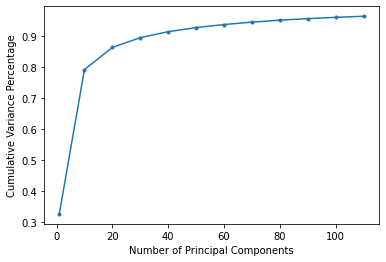

In [21]:
#Plot number of principal components vs cumulative explained variance.

plt.plot(df_PCA['num_components'], df_PCA['cum_pct_variance'], marker='.')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Percentage')
plt.show()

The plot below shows the number of principal components vs. cumulative explained variance as we increase the number of components. We reduce the dimensions of the training dataset and development dataset by transforming them with the fitted PCA and store them separately to be used for training.


In [22]:
# Transform training data and test data using PCA
X_train_2d_PCA = model_PCA.transform(X_train_2d)
X_test_PCA = model_PCA.transform(X_test)


def pca_transform(model, data, data_pca):
    model.fit(data)
    return model.transform(data_pca)


#X_blur_train_2d_PCA = pca_transform(model_PCA, X_blur_train_2d, X_blur_train_2d)
#X_blur_test_2d_PCA = pca_transform(model_PCA, X_blur_train_2d, X_blur_test_2d)

X_red_train_2d_PCA = pca_transform(model_PCA, X_red_train_2d, X_red_train_2d)
X_red_test_2d_PCA = pca_transform(model_PCA, X_red_train_2d, X_red_test_2d)
#blur_red_train_2d_PCA = pca_transform(model_PCA, blur_red_train_2d, blur_red_train_2d)
#blur_red_test_2d_PCA = pca_transform(model_PCA, blur_red_train_2d, blur_red_test_2d)

X_blue_train_2d_PCA = pca_transform(model_PCA, X_blue_train_2d, X_blue_train_2d)
X_blue_test_2d_PCA = pca_transform(model_PCA, X_blue_train_2d, X_blue_test_2d)
#blur_blue_train_2d_PCA = pca_transform(model_PCA, blur_blue_train_2d, blur_blue_train_2d)
#blur_blue_test_2d_PCA = pca_transform(model_PCA, blur_blue_train_2d, blur_blue_test_2d)

X_green_train_2d_PCA = pca_transform(model_PCA, X_green_train_2d, X_green_train_2d)
X_green_test_2d_PCA = pca_transform(model_PCA, X_green_train_2d, X_green_test_2d)
#blur_green_train_2d_PCA = pca_transform(model_PCA, blur_green_train_2d, blur_green_train_2d)
#blur_green_test_2d_PCA = pca_transform(model_PCA, blur_green_train_2d, blur_green_test_2d)

In [23]:
#training_list = [X_train_2d, X_train_2d_PCA, X_blur_train_2d_PCA, X_red_train_2d_PCA, 
                # blur_red_train_2d_PCA, X_blue_train_2d_PCA, blur_blue_train_2d_PCA,
                # X_green_train_2d_PCA, blur_green_train_2d_PCA]
#test_list = [X_test, X_test_PCA, X_blur_test_2d_PCA, X_red_test_2d_PCA, blur_red_test_2d_PCA, X_blue_test_2d_PCA,
                   # blur_blue_test_2d_PCA, X_green_test_2d_PCA, blur_green_test_2d_PCA]
#list_description = ['No_PCA', 'PCA', 'Blur_PCA', 'Red_PCA', 'Blur_Red_PCA', 'Blue_PCA', 'Blur_Blue_PCA',
                    #'Green_PCA', 'Blur_Green_PCA']

training_list = [X_train_2d, X_train_2d_PCA, X_red_train_2d_PCA, X_blue_train_2d_PCA, X_green_train_2d_PCA]
test_list = [X_test, X_test_PCA, X_red_test_2d_PCA,  X_blue_test_2d_PCA, X_green_test_2d_PCA]
list_description = ['No_PCA', 'PCA', 'Red_PCA',  'Blue_PCA','Green_PCA']

#### 4 Support Vector Machines

Let's now have a look to the support vector machine algorithm to predict our data. Support vector machines work by placing hyperplanes through the data in N-dimensional space when a simple linear line can not separate the data. 

We will run the RGB and blurred data through it along with transformations through PCA to determine which data set has the highest accuracy. From there we will tune the parameters C and gamma. 

In [24]:
model_SVC = SVC(random_state=0)
print("Support Vector Machine:")


scores = []
for tr, te in zip(training_list, test_list):
    model_SVC.fit(tr, Y_train_3d)
    scores.append("{:.1%}".format(model_SVC.score(te, Y_test_3d)))

df_SVC = pd.DataFrame(columns=['Data Description', 'Accuracy'])
i = 0
for desc, score in zip(list_description, scores):
    df_SVC.loc[i] = [desc, score]
    i += 1
    
df_SVC

Support Vector Machine:


,Data Description,Accuracy
0,No_PCA,46.7%
1,PCA,48.7%
2,Red_PCA,47.9%
3,Blue_PCA,48.7%
4,Green_PCA,48.2%


Tuning parameters for with PCA for classifier SVM
Best paramaters: {'C': 100, 'gamma': 0.01}
Best grid score: 0.680
Dev accuracy:  73.0
Classification Report

              precision    recall  f1-score   support

           1       0.66      0.61      0.63       100
           2       0.62      0.75      0.68       100
           3       0.77      0.79      0.78       100
           4       0.72      0.71      0.71       100
           5       0.40      0.72      0.52       100
           6       0.76      0.74      0.75       100
           7       0.84      0.81      0.82       100
           8       0.75      0.88      0.81       100
           9       0.84      0.76      0.80       100
          10       0.88      0.74      0.80       100
          11       0.80      0.76      0.78       100
          12       0.89      0.75      0.82       100
          13       0.66      0.70      0.68       100
          14       0.82      0.69      0.75       100
          15       0.75      0

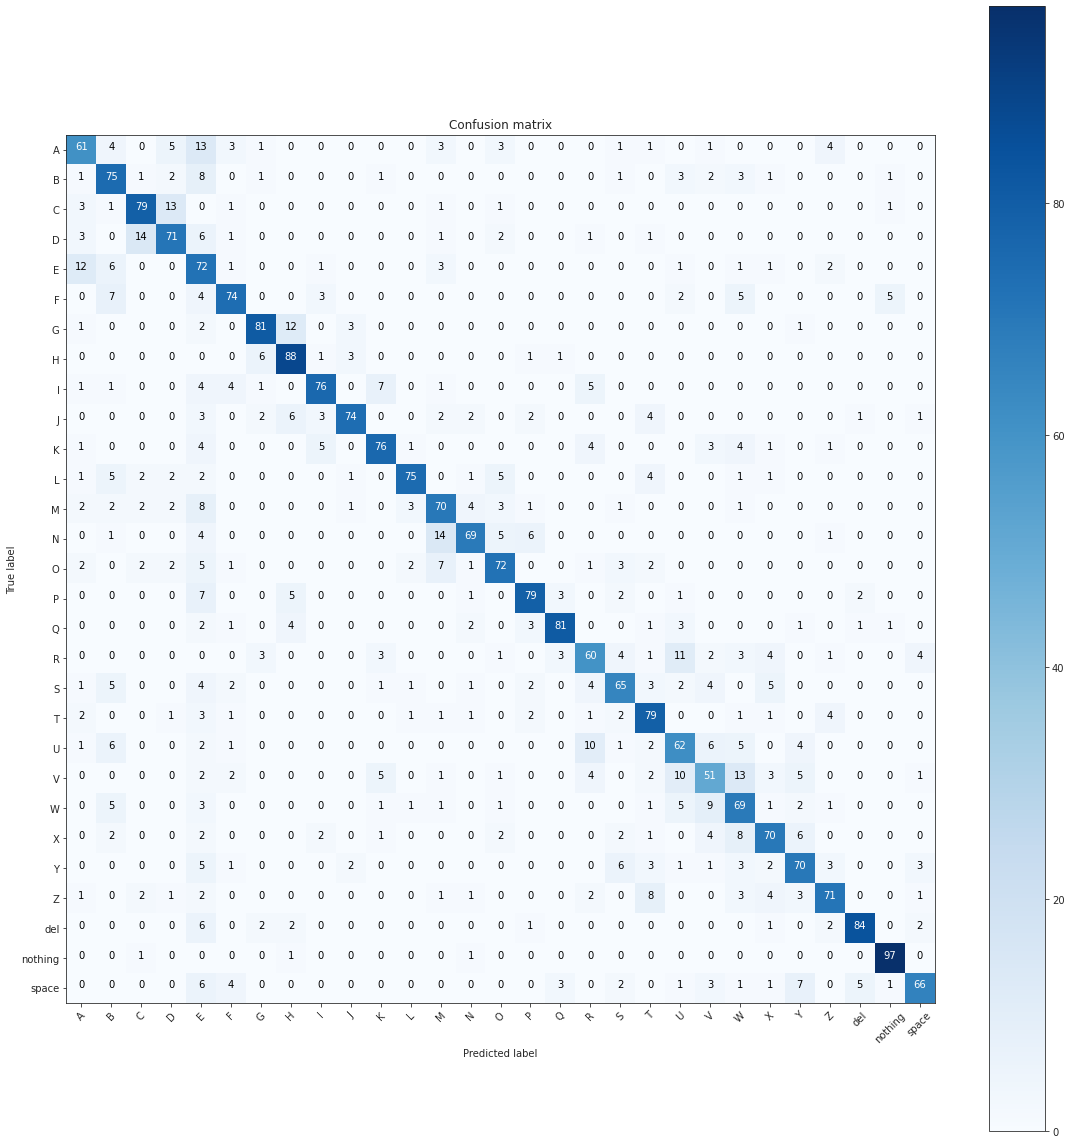

In [25]:
#GridSearch

c = [10, 100, 1000]
gamma = [0.001, 0.01, 0.1,]
params_list = {'C': c, 'gamma': gamma}
clf = SVC(kernel='rbf')    

gs = GridSearchCV(estimator=clf, param_grid=params_list, refit=True)
gs.fit(X_train_2d_PCA, Y_train_3d)
print('Tuning parameters for {} for classifier {}'.format("with PCA", "SVM"))
print('Best paramaters:', gs.best_params_)
print('Best grid score: {:.3f}'.format(gs.best_score_))

# Fit and score with the best parameter found
clf.set_params(**gs.best_params_)
clf.fit(X_train_2d_PCA, Y_train_3d)

dev_pred = gs.predict(X_test_PCA)
print("Dev accuracy: ", 100*np.sum(dev_pred == Y_test_3d)/X_test_PCA.shape[0])


print("Classification Report\n")
print(classification_report(Y_test_3d, dev_pred))


plot_confusion_matrix_with_default_options(y_pred=dev_pred, y_true=Y_test_3d,classes=letters)



In [ ]:

model_SVC = SVC(random_state=0)
model = SVC(kernel='rbf')

param = {'C': 100, 'gamma': 0.01}
model.set_params(**param)
’
model.fit(X_train_2d_PCA, Y_train_3d)

dev_pred = model.predict(X_test_PCA)
print("Dev accuracy: ", 100*np.sum(dev_pred ==  Y_test_3d)/X_test_PCA.shape[0])


print("Classification Report\n")
print(classification_report( Y_test_3d, dev_pred))

cm = confusion_matrix( Y_test_3d, dev_pred)
with sns.axes_style('ticks'):
    plt.figure(figsize=(16, 16))
    plot_confusion_matrix(cm, letters)
    plt.show()

After performing a grid search we have found the optimal parameters for C and gamma. 

C, also known as regularization, will choose a smaller-margin hyperplane to make sure all the data is classified correctly for large values of C. For small values of C, it will look for a larger-margin hyperplane even if that means misclassifying points. Our model found a C value somewhere in the middle to be optimal for our case. 

For the gamma parameter : a low gamma means points far from the likely separation line are considered in the calculation while a high gamma means points close to the separation line are considered in the calculation. Our optimal gamma value was fairly low which could mean our data was sparse and far from the decision boundary.

After performing the gridsearch on the these two parameters, we were able to increase our accuracy from 60.9% up to 67.0%.